This notebook objective is to create vector database for different models available at Hugging Face

# Import Libraries

In [50]:
#pip install chromadb --upgrade


In [51]:
# Hugging Face
from transformers import AutoImageProcessor, ViTModel, DeiTModel, SwinModel,ResNetModel
from datasets import load_dataset

# torch
import torch
from torchvision.io import read_image

#others

import chromadb
import math
import os
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import collections
import pickle

# Defining Constants

In [52]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS=["google/vit-base-patch16-224","microsoft/swin-tiny-patch4-window7-224","facebook/deit-base-distilled-patch16-224","microsoft/resnet-50"]
TOTAL_IMAGES=4869
label_to_images=collections.defaultdict(int)

# Connecting to Hugging Face datasets

In [53]:
ds = load_dataset("fcakyon/pokemon-classification", name="full")
d_img= ds['train'][0] # first image
d_img

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/94604512981365-config-parquet-and-info-fcakyon-pokemon-classific-5a7ec0aa/downloads/extracted/bc050261dd5fc328e3d0cd4b7691b80c02abcc5a470596873ef1adfd683f07d5/Abra/0282b2f3a22745f1a436054ea15a0ae5_jpg.rf.8672478a3b97f7c0c5b6737c3fd2d3d8.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'labels': 80}

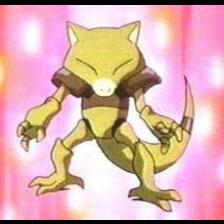

In [54]:
d_img["image"]

In [55]:
len(ds["train"])

4869

# Create a ChromaDB persistent Client

In [56]:
client = chromadb.PersistentClient(path="VectorDB")

In [57]:
MODELS

['google/vit-base-patch16-224',
 'microsoft/swin-tiny-patch4-window7-224',
 'facebook/deit-base-distilled-patch16-224',
 'microsoft/resnet-50']

In [58]:
#client.delete_collection('vitbasepatch16224')
#client.delete_collection('swintinypatch4window7224')
#client.delete_collection('deitbasedistilledpatch16224')
#client.delete_collection('resnet50')

# Create a function which create vectors using all available models and save those vectors in Vector DB

In [59]:
def vectorize(image,processor,model,model_name):
  
  inputs = processor(image, return_tensors="pt")

  with torch.no_grad():
      outputs = model(**inputs)

  last_hidden_states = outputs.last_hidden_state
  #print(last_hidden_states.shape,model_name)
  if model_name == "microsoft/swin-tiny-patch4-window7-224":
    pooled_vector = last_hidden_states.mean(dim=1)
    #print(pooled_vector.shape,"SWIN")
    return pooled_vector
  elif model_name=="microsoft/resnet-50":
    features = outputs.pooler_output.squeeze()
    return features
  else:
    return last_hidden_states[0] # return the last hidden state without batch dimension


In [60]:
def add_vectors(collection,model_name,limit_num=TOTAL_IMAGES+1):
    outer_loop_range = math.ceil(TOTAL_IMAGES / 1000)
    
    processor = AutoImageProcessor.from_pretrained(model_name)
  
    if model_name=="microsoft/swin-tiny-patch4-window7-224":
        model = SwinModel.from_pretrained(model_name)
    elif model_name =="google/vit-base-patch16-224":
        model = ViTModel.from_pretrained(model_name)
    elif model_name=="microsoft/resnet-50":
        model = ResNetModel.from_pretrained("microsoft/resnet-50")
    else:
        model = DeiTModel.from_pretrained(model_name)
    
    for i in range(0, outer_loop_range):
        inner_loop_start = i * 1000
        inner_loop_end = min((i * 1000) + 1000, TOTAL_IMAGES)
        
        # Inner loop with progress bar
        for j in tqdm(range(inner_loop_start, inner_loop_end), desc="Processing Images"):
            if limit_num == j:
                return
            
            try:
                d_image= ds["train"][j] #image dictionary
                #update the label_to_images dictionary
                label_to_images[d_image["labels"]]+=1
                
                image = d_image["image"]
                if model_name=="microsoft/resnet-50":  
                    vector = vectorize(image,processor,model,model_name).tolist()
                else:
                    vector = vectorize(image,processor,model,model_name)[0].tolist()
                collection.add(embeddings=[vector], ids=[str(j)])
            except Exception as e:
                print(e)
                print(f"At {j} unable to vectorize {e}")


In [70]:
def GlobalVectorizer(MODELS=MODELS,limit_num=TOTAL_IMAGES+1):
    flag=True
    for model_name in MODELS:
        
        print(model_name)
        
        #------------- vectorizing the images------------
        
        #create a collection
        slash=model_name.index('/')
        name = ''.join(model_name[slash+1:].split('-'))
        print(name)
        try:
            collection = client.get_or_create_collection("Hello")
        except Exception as e:
            print(e)
            return 
        
        add_vectors(collection,model_name,limit_num=limit_num)
        
        if flag: # should update only once
            
            print(label_to_images)
            with open("label_to_images.pkl","wb") as f:
                pickle.dump(label_to_images,f)
            flag=False
        
        

In [69]:
GlobalVectorizer()

In [17]:
len(label_to_images)

110